In [2]:
import os
import cv2
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from torchvision import models
import matplotlib.pyplot as plt

In [3]:
# ----------------------------
# 1. TIỀN XỬ LÝ ẢNH
# ----------------------------
def preprocess_image(path, target_size=96):
    # Đọc ảnh ở dạng grayscale (ảnh xám)
    img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    # Nếu ảnh không đọc được (None) thì trả về None
    if img is None:
        return None 
    # Resize ảnh về kích thước 256x256 để chuẩn hóa bước xử lý tiếp theo
    img = cv2.resize(img, (256, 256)) 
    # Chuyển ảnh sang ảnh nhị phân: ngưỡng hóa bằng phương pháp Otsu và đảo màu (đen thành trắng)
    _, binary = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU) 
    # Tìm các đường bao (contours) ngoài cùng trong ảnh nhị phân
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    # Lọc các contours có diện tích nhỏ hơn 50 (loại nhiễu)
    contours = [cnt for cnt in contours if cv2.contourArea(cnt) > 50]
    # Nếu không tìm thấy contour nào hợp lệ thì trả về None
    if not contours:
        return None
    # Lấy contour có diện tích lớn nhất (giả định là chữ số cần nhận dạng)
    cnt = max(contours, key=cv2.contourArea)
    # Lấy tọa độ hình chữ nhật bao quanh contour lớn nhất
    x, y, w, h = cv2.boundingRect(cnt)
    # Cắt vùng chứa chữ số ra khỏi ảnh nhị phân
    digit = binary[y:y+h, x:x+w]
    # Tạo một ảnh vuông có kích thước bằng max(w, h), để đặt chữ số vào giữa
    size_max = max(w, h)
    square = np.zeros((size_max, size_max), dtype=np.uint8)  # Tạo ảnh nền đen
    # Tính toán vị trí để chèn chữ số vào giữa ảnh vuông
    x_offset = (size_max - w) // 2
    y_offset = (size_max - h) // 2
    # Chèn ảnh chữ số vào giữa ảnh vuông
    square[y_offset:y_offset+h, x_offset:x_offset+w] = digit
    # Resize ảnh về kích thước mong muốn (ví dụ: 96x96)
    resized = cv2.resize(square, (target_size, target_size), interpolation=cv2.INTER_AREA)
    # Chuẩn hóa ảnh về dạng float32, giá trị từ 0 đến 1
    normalized = resized.astype('float32') / 255.0
    # Thêm kênh màu đơn (1 channel) để phù hợp với input của mô hình CNN
    normalized = normalized.reshape(target_size, target_size, 1)
    # Thêm chiều batch (1 ảnh) để phù hợp với input cho model dự đoán
    return np.expand_dims(normalized, axis=0)

In [4]:
# ----------------------------
# 2. CUSTOM DATASET
# ----------------------------
class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, target_size=96):
        # Khởi tạo danh sách lưu các mẫu dữ liệu hợp lệ (sau khi tiền xử lý)
        self.valid_data = []
        # Duyệt qua từng ảnh và nhãn tương ứng
        for path, label in zip(image_paths, labels):
            # Tiền xử lý ảnh theo hàm đã định nghĩa ở trên
            img = preprocess_image(path, target_size)
            # Nếu ảnh sau tiền xử lý không bị lỗi thì lưu vào danh sách
            if img is not None:
                self.valid_data.append((img, label))
    def __len__(self):
        # Trả về số lượng mẫu dữ liệu hợp lệ (dùng cho DataLoader)
        return len(self.valid_data)
    def __getitem__(self, idx):
        # Lấy ảnh và nhãn tại chỉ số idx
        img, label = self.valid_data[idx]
        # Chuyển ảnh từ numpy array sang Tensor, sắp xếp lại thứ tự các chiều:
        # Từ (1, H, W, C) → (C, H, W) vì PyTorch yêu cầu ảnh có shape (C, H, W)
        img_tensor = torch.tensor(img, dtype=torch.float32).permute(0, 3, 1, 2).squeeze(0)
        # Trả về ảnh và nhãn tương ứng
        return img_tensor, label

In [5]:
# ----------------------------
# 3. LOAD DỮ LIỆU
# ----------------------------
def load_image_paths_and_labels(root_dir):
    # Khởi tạo 2 danh sách rỗng: một để lưu đường dẫn ảnh, một để lưu nhãn
    image_paths, labels = [], []
    # Duyệt qua từng thư mục con trong thư mục gốc (mỗi thư mục là 1 lớp/label)
    for label in os.listdir(root_dir):
        label_path = os.path.join(root_dir, label)  # Đường dẫn đầy đủ tới thư mục lớp
        # Nếu không phải là thư mục thì bỏ qua (phòng trường hợp có file rác)
        if not os.path.isdir(label_path):
            continue
        # Duyệt qua từng file trong thư mục lớp
        for filename in os.listdir(label_path):
            # Chỉ lấy các file có định dạng ảnh phổ biến
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                # Thêm đường dẫn ảnh vào danh sách
                image_paths.append(os.path.join(label_path, filename))
                # Thêm nhãn tương ứng (được lấy từ tên thư mục – giả định là số)
                labels.append(int(label))
    # Trả về danh sách đường dẫn ảnh và danh sách nhãn tương ứng
    return image_paths, labels

In [6]:
# ----------------------------
# 4. HIỂN THỊ ẢNH MẪU
# ----------------------------
def show_first_n_images(dataset, n=5):
    # Tạo một figure kích thước rộng (dài 15 inch, cao 3 inch)
    plt.figure(figsize=(15, 3))
    # Duyệt qua n ảnh đầu tiên trong tập dữ liệu
    for i in range(n):
        # Lấy ảnh và nhãn tương ứng tại chỉ số i
        img_tensor, label = dataset[i]
        # Loại bỏ chiều channel nếu ảnh có dạng (1, H, W), rồi chuyển sang numpy để hiển thị
        img_np = img_tensor.squeeze().numpy()
        # Tạo subplot thứ i+1 (trên 1 dòng, có n ảnh)
        plt.subplot(1, n, i+1)
        # Hiển thị ảnh với màu xám
        plt.imshow(img_np, cmap='gray')
        # Hiển thị nhãn phía trên ảnh
        plt.title(f"Label: {label}")
        # Ẩn trục để ảnh gọn gàng hơn
        plt.axis('off')
    # Tự động căn chỉnh bố cục cho đẹp
    plt.tight_layout()
    # Hiển thị hình ảnh
    plt.show()

In [7]:
# ----------------------------
# 5. TRAIN MODEL
# ----------------------------
def train(model, loader, criterion, optimizer, device):
    # Đưa mô hình vào chế độ huấn luyện (bật dropout, batchnorm nếu có)
    model.train()
    # Khởi tạo biến tổng loss và số lượng mẫu đúng
    total_loss = 0
    correct = 0
    total = 0
    # Duyệt qua từng batch dữ liệu trong DataLoader
    for images, labels in loader:
        # Đưa ảnh và nhãn sang thiết bị (CPU hoặc GPU)
        images, labels = images.to(device), labels.to(device)
        # Đặt lại gradient về 0 trước mỗi bước lan truyền ngược
        optimizer.zero_grad()
        # Dự đoán đầu ra từ mô hình
        outputs = model(images)
        # Tính toán hàm mất mát giữa dự đoán và nhãn thật
        loss = criterion(outputs, labels)
        # Lan truyền ngược (backpropagation) để tính gradient
        loss.backward()
        # Cập nhật trọng số mô hình bằng optimizer
        optimizer.step()
        # Cộng dồn giá trị loss của batch hiện tại
        total_loss += loss.item()
        # Lấy nhãn dự đoán: chỉ số có giá trị lớn nhất trong mỗi dòng output
        _, predicted = torch.max(outputs, 1)
        # Cộng tổng số mẫu và số mẫu dự đoán đúng
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    # Tính loss trung bình trên toàn tập train
    avg_loss = total_loss / len(loader)
    # Tính độ chính xác (accuracy) theo phần trăm
    acc = 100 * correct / total
    # In kết quả loss và accuracy của epoch hiện tại
    print(f"Train loss: {avg_loss:.4f} - Accuracy: {acc:.2f}%")
    # Trả về loss trung bình và accuracy để lưu lại hoặc vẽ biểu đồ
    return avg_loss, acc

In [8]:
# ----------------------------
# 6. TEST MODEL
# ----------------------------
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns

def test(model, loader, criterion, device, show_detailed_metrics=False, class_names=None):
    # Đưa mô hình vào chế độ đánh giá (tắt dropout, batchnorm...)
    model.eval()
    # Khởi tạo biến để tính loss, số lượng đúng, tổng số mẫu
    total_loss = 0
    correct = 0
    total = 0
    # Danh sách lưu nhãn dự đoán và nhãn thật để đánh giá
    all_preds = []
    all_labels = []
    # Không tính gradient để tiết kiệm bộ nhớ
    with torch.no_grad():
        for images, labels in loader:
            # Chuyển dữ liệu sang thiết bị (CPU hoặc GPU)
            images, labels = images.to(device), labels.to(device)
            # Cho ảnh đi qua mô hình để lấy đầu ra
            outputs = model(images)
            # Tính loss của batch hiện tại
            loss = criterion(outputs, labels)
            total_loss += loss.item()
            # Lấy nhãn dự đoán: chỉ số có giá trị lớn nhất trong mỗi hàng (class có xác suất cao nhất)
            preds = outputs.argmax(dim=1)
            # Tính số mẫu dự đoán đúng và tổng số mẫu
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            # Lưu dự đoán và nhãn thật ra danh sách
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    # Tính loss trung bình và accuracy (%) toàn bộ tập kiểm tra
    avg_loss = total_loss / len(loader)
    acc = 100 * correct / total
    print(f"Test loss: {avg_loss:.4f} - Accuracy: {acc:.2f}%")
    # Nếu yêu cầu in chi tiết theo từng lớp
    if show_detailed_metrics:
        # Chuyển list thành numpy array để xử lý
        all_preds_np = np.array(all_preds)
        all_labels_np = np.array(all_labels)
        unique_classes = np.unique(all_labels_np)
        # In độ chính xác của từng lớp
        print("\n==> Accuracy từng lớp:")
        for cls in unique_classes:
            # Lấy tên lớp (dưới dạng chuỗi nếu có danh sách class_names)
            cls_name = class_names[cls] if class_names else str(cls)
            # Tổng số mẫu của lớp này
            cls_total = np.sum(all_labels_np == cls)
            # Số mẫu được dự đoán đúng thuộc lớp này
            cls_correct = np.sum((all_labels_np == cls) & (all_preds_np == cls))
            # Tính accuracy (%) của lớp
            cls_acc = 100 * cls_correct / cls_total if cls_total > 0 else 0.0
            print(f"Lớp {cls_name}: {cls_acc:.2f}%")
        # Vẽ ma trận nhầm lẫn (confusion matrix)
        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                    xticklabels=class_names if class_names else np.unique(all_labels),
                    yticklabels=class_names if class_names else np.unique(all_labels))
        plt.title("Confusion Matrix")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.tight_layout()
        plt.show()
    # Trả về loss và accuracy để ghi lại hoặc vẽ biểu đồ
    return avg_loss, acc

In [9]:
# ----------------------------
# 7. DỰ ĐOÁN THƯ MỤC MỚI
# ----------------------------
def predict_digits_from_folder(model, input_folder, output_csv, device='cpu', target_size=96):
    # Đưa mô hình vào chế độ đánh giá
    model.eval()
    # Danh sách kết quả [tên file, nhãn dự đoán]
    results = []
    # Duyệt qua các file ảnh trong thư mục đầu vào (được sắp xếp theo tên)
    for filename in sorted(os.listdir(input_folder)):
        # Bỏ qua các file không phải ảnh
        if not filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            continue
        # Lấy đường dẫn đầy đủ đến file ảnh
        path = os.path.join(input_folder, filename)
        # Tiền xử lý ảnh (trả về None nếu lỗi)
        img = preprocess_image(path, target_size)
        if img is None:
            print(f"⚠️ Bỏ qua ảnh lỗi: {filename}")
            continue
        # Chuyển ảnh sang Tensor và định hình đúng chuẩn (BCHW)
        img_tensor = torch.tensor(img, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
        # Dự đoán nhãn của ảnh
        with torch.no_grad():
            output = model(img_tensor)
            pred = output.argmax(dim=1).item()
        # Thêm kết quả vào danh sách: [tên file, nhãn dự đoán]
        results.append([filename, pred])
    # Ghi kết quả ra file CSV với cột: filename, predicted_label
    pd.DataFrame(results, columns=["filename", "predicted_label"]).to_csv(output_csv, index=False)
    # In thông báo hoàn tất
    print(f"✅ Ghi kết quả vào: {output_csv}")

In [10]:
# ----------------------------
# 1. Setup Dataset
# ----------------------------
def prepare_datasets(root_dir, target_size=96, test_size=0.2):
    # Gọi hàm để lấy danh sách đường dẫn ảnh và nhãn từ thư mục dữ liệu
    image_paths, labels = load_image_paths_and_labels(root_dir)
    # Chia dữ liệu thành 2 phần: train và test theo tỷ lệ test_size
    # - Dùng `stratify=labels` để đảm bảo tỷ lệ phân bố các lớp đều trong cả train và test
    # - random_state=42 để đảm bảo kết quả chia luôn giống nhau (tái lập được)
    x_train, x_test, y_train, y_test = train_test_split(
        image_paths, labels, test_size=test_size, stratify=labels, random_state=42
    )
    # Tạo tập dữ liệu huấn luyện từ ảnh và nhãn đã chia
    train_dataset = CustomDataset(x_train, y_train, target_size=target_size)
    # Tạo tập dữ liệu kiểm tra từ ảnh và nhãn còn lại
    test_dataset = CustomDataset(x_test, y_test, target_size=target_size)
    # Trả về hai tập dữ liệu để dùng cho huấn luyện và đánh giá
    return train_dataset, test_dataset

In [11]:

# ----------------------------
# 2. Data Loaders
# ----------------------------
def get_dataloaders(train_dataset, test_dataset, batch_size_train=32, batch_size_test=64):
    # Tạo DataLoader cho tập huấn luyện
    # - shuffle=True để xáo trộn dữ liệu mỗi epoch, giúp mô hình học tốt hơn
    train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)
    # Tạo DataLoader cho tập kiểm tra
    # - Không cần shuffle vì không huấn luyện
    test_loader = DataLoader(test_dataset, batch_size=batch_size_test)
    # Trả về hai DataLoader cho huấn luyện và kiểm tra
    return train_loader, test_loader

In [12]:
# ----------------------------
# 3. Khởi tạo mô hình ResNet
# ----------------------------
def build_model(num_classes=10):
    # Xác định thiết bị sử dụng: GPU nếu có, ngược lại dùng CPU
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Tải mô hình ResNet-18 pretrained (ImageNet)
    model = models.resnet18(weights=True)
    # Sửa lớp đầu vào conv1 để nhận ảnh xám (1 kênh thay vì 3 kênh RGB)
    # Input: (batch_size, 1, 96, 96) → Output: (batch_size, 64, 48, 48)
    model.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    # Sửa lớp fully-connected cuối cùng để phù hợp với số lớp cần phân loại (ví dụ: 10 lớp cho chữ số)
    # Input: (batch_size, 512) → Output: (batch_size, num_classes)
    model.fc = nn.Linear(model.fc.in_features, num_classes)
    # Trả về mô hình sau khi chuyển sang thiết bị thích hợp (CPU/GPU)
    return model.to(device), device

In [13]:
# ----------------------------
# 4. Vẽ biểu đồ Loss/Accuracy
# ----------------------------
def plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, 'bo-', label='Train Loss')
    plt.plot(epochs, test_losses, 'ro-', label='Test Loss')
    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, 'bo-', label='Train Accuracy')
    plt.plot(epochs, test_accuracies, 'ro-', label='Test Accuracy')
    plt.title('Accuracy per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

In [14]:

# ----------------------------
# 5. Train & Evaluate
# ----------------------------
def train_and_evaluate(model, train_loader, test_loader, criterion, optimizer, device, num_epochs=20):
    # Danh sách lưu lại loss và accuracy theo từng epoch
    train_losses, train_accuracies = [], []
    test_losses, test_accuracies = [], []
    # Lặp qua từng epoch
    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}")
        # Huấn luyện mô hình trong 1 epoch, trả về loss và accuracy trên tập train
        train_loss, train_acc = train(model, train_loader, criterion, optimizer, device)
        # Đánh giá mô hình sau mỗi epoch trên tập test (in nhanh)
        test_loss, test_acc = test(model, test_loader, criterion, device)
        # Nếu là epoch cuối (epoch 20), hiển thị chi tiết thêm: confusion matrix + classification report
        show_detailed = (epoch == 20)
        test_loss, test_acc = test(
            model, test_loader, criterion, device,
            show_detailed_metrics=show_detailed,
            class_names=[str(i) for i in range(10)]  # tên lớp là "0" đến "9"
        )
        # Lưu lại kết quả để vẽ biểu đồ hoặc phân tích sau
        train_losses.append(train_loss)
        train_accuracies.append(train_acc)
        test_losses.append(test_loss)
        test_accuracies.append(test_acc)
    # Trả về toàn bộ log huấn luyện và đánh giá theo từng epoch
    return train_losses, test_losses, train_accuracies, test_accuracies

In [15]:
# ----------------------------
# 6. MAIN FUNCTION
# ----------------------------
def main():
    root_dir = r"C:\\Users\\ADMIN\\Desktop\\ML\\sort_images\\sort_images"
    INPUT_FOLDER = r"C:\\Users\\ADMIN\\Desktop\\ML\\data.2025"
    OUTPUT_CSV = r"C:\\Users\\ADMIN\\Desktop\\ML\\sub_resnet.csv"
    target_size = 96

    # 1. Chuẩn bị dữ liệu
    train_dataset, test_dataset = prepare_datasets(root_dir, target_size)
    show_first_n_images(train_dataset, n=5)

    # 2. DataLoader
    train_loader, test_loader = get_dataloaders(train_dataset, test_dataset)

    # 3. Model
    model, device = build_model()

    # 4. Loss & Optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # 5. Train + Test
    train_losses, test_losses, train_accuracies, test_accuracies = train_and_evaluate(
        model, train_loader, test_loader, criterion, optimizer, device, num_epochs=50
    )

    # 6. Vẽ biểu đồ
    plot_metrics(train_losses, test_losses, train_accuracies, test_accuracies)

    # 7. Dự đoán ảnh trong thư mục
    predict_digits_from_folder(model, INPUT_FOLDER, OUTPUT_CSV, device=device, target_size=target_size)

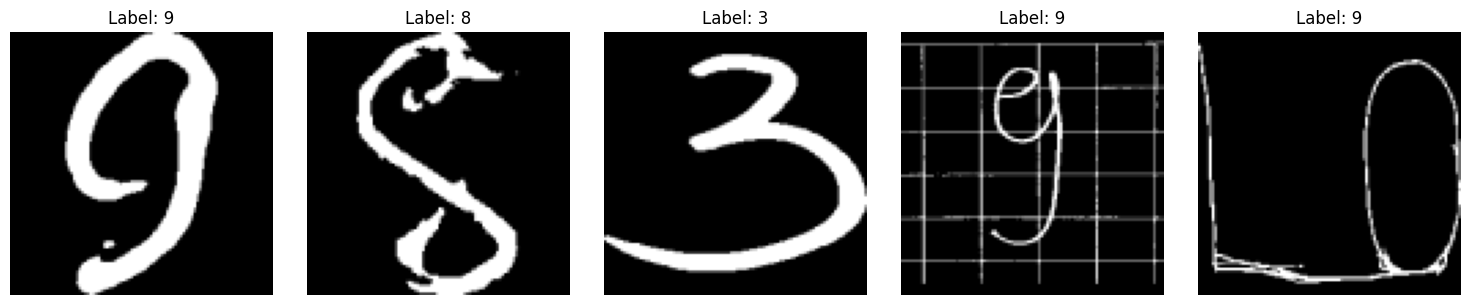

C:\Users\ADMIN\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)



Epoch 1
Train loss: 1.2950 - Accuracy: 57.48%
Test loss: 0.9534 - Accuracy: 69.00%
Test loss: 0.9534 - Accuracy: 69.00%

Epoch 2
Train loss: 0.7465 - Accuracy: 76.04%
Test loss: 0.7016 - Accuracy: 77.92%
Test loss: 0.7016 - Accuracy: 77.92%

Epoch 3
Train loss: 0.5758 - Accuracy: 81.73%
Test loss: 0.6926 - Accuracy: 78.96%
Test loss: 0.6926 - Accuracy: 78.96%

Epoch 4
Train loss: 0.4243 - Accuracy: 86.20%
Test loss: 0.6268 - Accuracy: 80.52%
Test loss: 0.6268 - Accuracy: 80.52%

Epoch 5
Train loss: 0.4087 - Accuracy: 86.84%
Test loss: 0.5107 - Accuracy: 83.20%
Test loss: 0.5107 - Accuracy: 83.20%

Epoch 6
Train loss: 0.3369 - Accuracy: 88.83%
Test loss: 0.6139 - Accuracy: 80.00%
Test loss: 0.6139 - Accuracy: 80.00%

Epoch 7
Train loss: 0.2980 - Accuracy: 90.33%
Test loss: 0.5914 - Accuracy: 83.79%
Test loss: 0.5914 - Accuracy: 83.79%

Epoch 8
Train loss: 0.2807 - Accuracy: 90.92%
Test loss: 0.5274 - Accuracy: 83.05%
Test loss: 0.5274 - Accuracy: 83.05%

Epoch 9
Train loss: 0.2470 - Ac

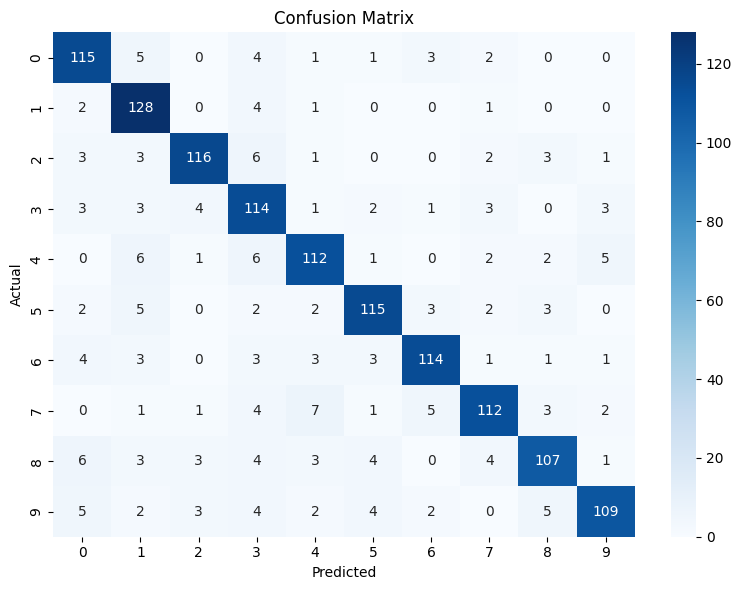


Epoch 21
Train loss: 0.1261 - Accuracy: 95.55%
Test loss: 0.6955 - Accuracy: 84.09%
Test loss: 0.6955 - Accuracy: 84.09%

Epoch 22
Train loss: 0.1044 - Accuracy: 96.20%
Test loss: 0.7166 - Accuracy: 84.01%
Test loss: 0.7166 - Accuracy: 84.01%

Epoch 23
Train loss: 0.1113 - Accuracy: 95.91%
Test loss: 0.5894 - Accuracy: 85.72%
Test loss: 0.5894 - Accuracy: 85.72%

Epoch 24
Train loss: 0.1108 - Accuracy: 96.18%
Test loss: 0.5658 - Accuracy: 86.02%
Test loss: 0.5658 - Accuracy: 86.02%

Epoch 25
Train loss: 0.1022 - Accuracy: 96.55%
Test loss: 0.6543 - Accuracy: 84.68%
Test loss: 0.6543 - Accuracy: 84.68%

Epoch 26
Train loss: 0.0852 - Accuracy: 96.79%
Test loss: 0.7007 - Accuracy: 84.68%
Test loss: 0.7007 - Accuracy: 84.68%

Epoch 27
Train loss: 0.0967 - Accuracy: 96.33%
Test loss: 0.7240 - Accuracy: 83.79%
Test loss: 0.7240 - Accuracy: 83.79%

Epoch 28
Train loss: 0.1122 - Accuracy: 96.29%
Test loss: 0.6277 - Accuracy: 85.28%
Test loss: 0.6277 - Accuracy: 85.28%

Epoch 29
Train loss: 0.

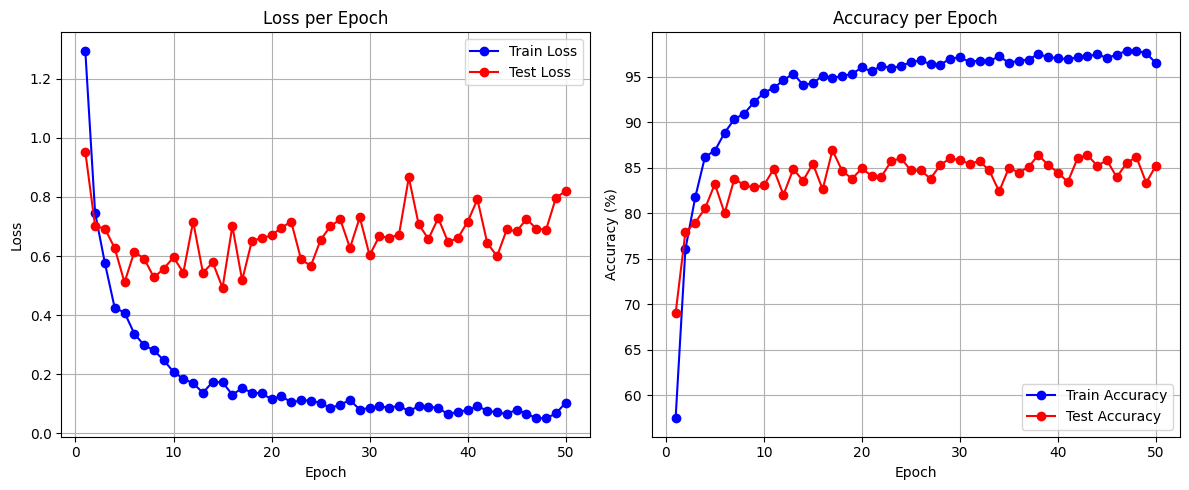

⚠️ Bỏ qua ảnh lỗi: 21151445fd63ff79440449974f17109d.jpg
⚠️ Bỏ qua ảnh lỗi: 2c18ee0e7cea8354149df435532d74ae.jpeg
⚠️ Bỏ qua ảnh lỗi: 3a816aa78f56749a0822d700ff560924.jpeg
⚠️ Bỏ qua ảnh lỗi: 48ed5388b8847d294b5d6c6ae680b8fd.png
⚠️ Bỏ qua ảnh lỗi: 4abc1b5dcf1be1de6503dc072e132fa0.jpeg
⚠️ Bỏ qua ảnh lỗi: 70ebf0bec317006017a54d6c9172af45.jpeg
⚠️ Bỏ qua ảnh lỗi: 868f0b6f0a2a3f6e00adff51489d1be1.png
⚠️ Bỏ qua ảnh lỗi: 8eeee227b3f244e980b747387bc79bf2.jpeg
⚠️ Bỏ qua ảnh lỗi: 9e748b9617e26b90011f8d7c3f8a7eee.jpeg
⚠️ Bỏ qua ảnh lỗi: a008f795ae8498751f2e5feeb0b73387.jpeg
⚠️ Bỏ qua ảnh lỗi: c72346cca85b4856842bdfde6af12e78.jpg
⚠️ Bỏ qua ảnh lỗi: ce2388179ec73203a60d8efedd04e0f1.jpeg
⚠️ Bỏ qua ảnh lỗi: d0541145b74fa2ae9c1f9c80b48519b0.png
⚠️ Bỏ qua ảnh lỗi: d4b080c6ce4933f1199fad7f75e7d112.jpeg
⚠️ Bỏ qua ảnh lỗi: e21dcb1cb0571a21a013b4232d1b6a13.jpeg
⚠️ Bỏ qua ảnh lỗi: f7679411e290bfd8dc90b3eadb57460a.jpeg
⚠️ Bỏ qua ảnh lỗi: f9afa3a3a3e90898daa13cee2264cf57.jpg
⚠️ Bỏ qua ảnh lỗi: ffd4f9df7163f55474

In [16]:
if __name__ == "__main__":
    main()

In [17]:
# dựa vào độ chính xác qua các epoch ta thấy độ chính xác của mô hình rôi vào khoảng 85% (tốt hơn cnn)
# các số có độ chính xác cao như là 1,8,6 
# các số có độ chính xác thấp như là 9,4
# về ma trận nhầm lẫn thì hầu như đường chéo chính chiếm ưu thế so với các ô còn lại 
# Tuy các số dự đoán vãn còn xảy ra tình trạng nhầm lẫn nhau nhưng nhìn chung phần nhấm lẫn không quá 10 chữ số cho thấy mô hình đã có cải thiện hơn 
# rất nhiều so với cnn 
# Bên cạnh đó việc xuất hiện thêm các ô số 0 trong ma trận nhầm lẫn cho thấy độ chính xác của bài toán đã được cải thiện rất nhiều 
